In [45]:
from torchvision.transforms import Resize, Compose, Grayscale
from datasets.pneumonia_dataset import PneumoniaDataset
import matplotlib.pyplot as plt
from models.cnns import ResNet, SmallCNN
from train_utils import train
import torch
from torch.utils.data import DataLoader, ConcatDataset, Subset
from sklearn.model_selection import train_test_split
import numpy as np
import random
import warnings

warnings.filterwarnings( "ignore", module = "matplotlib\..*" )

In [2]:
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)


# Exploratory data analysis

### Loading data

In [3]:
resize_transform = Resize((224,224)) # the images are large and have differing shapes
train_dataset_orig = PneumoniaDataset("data/chest_xray/train", resize_transform, use_rgb=False)
val_dataset_orig = PneumoniaDataset("data/chest_xray/val", resize_transform, use_rgb=False)

/home/lrabuzin/.conda/envs/ML4HC/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [4]:
total_dataset = ConcatDataset([train_dataset_orig, val_dataset_orig])
train_idx, validation_idx = train_test_split(np.arange(len(total_dataset)),
                                             test_size=0.1,
                                             random_state=seed,
                                             shuffle=True,
                                             stratify=train_dataset_orig.labels+val_dataset_orig.labels)

train_dataset = Subset(total_dataset, train_idx)
val_dataset = Subset(total_dataset, validation_idx)

Due to the small size of the validation dataset, the estimates of the generalization performance we use when performing model selection would turn out inaccurate, therefore, we construct a different train/validation split. We combine the original train and validation datasets and then perform a stratified split with ratios 9:1. We perform a stratified split in order to retain class proportions present in the original dataset.

### Visualising image examples

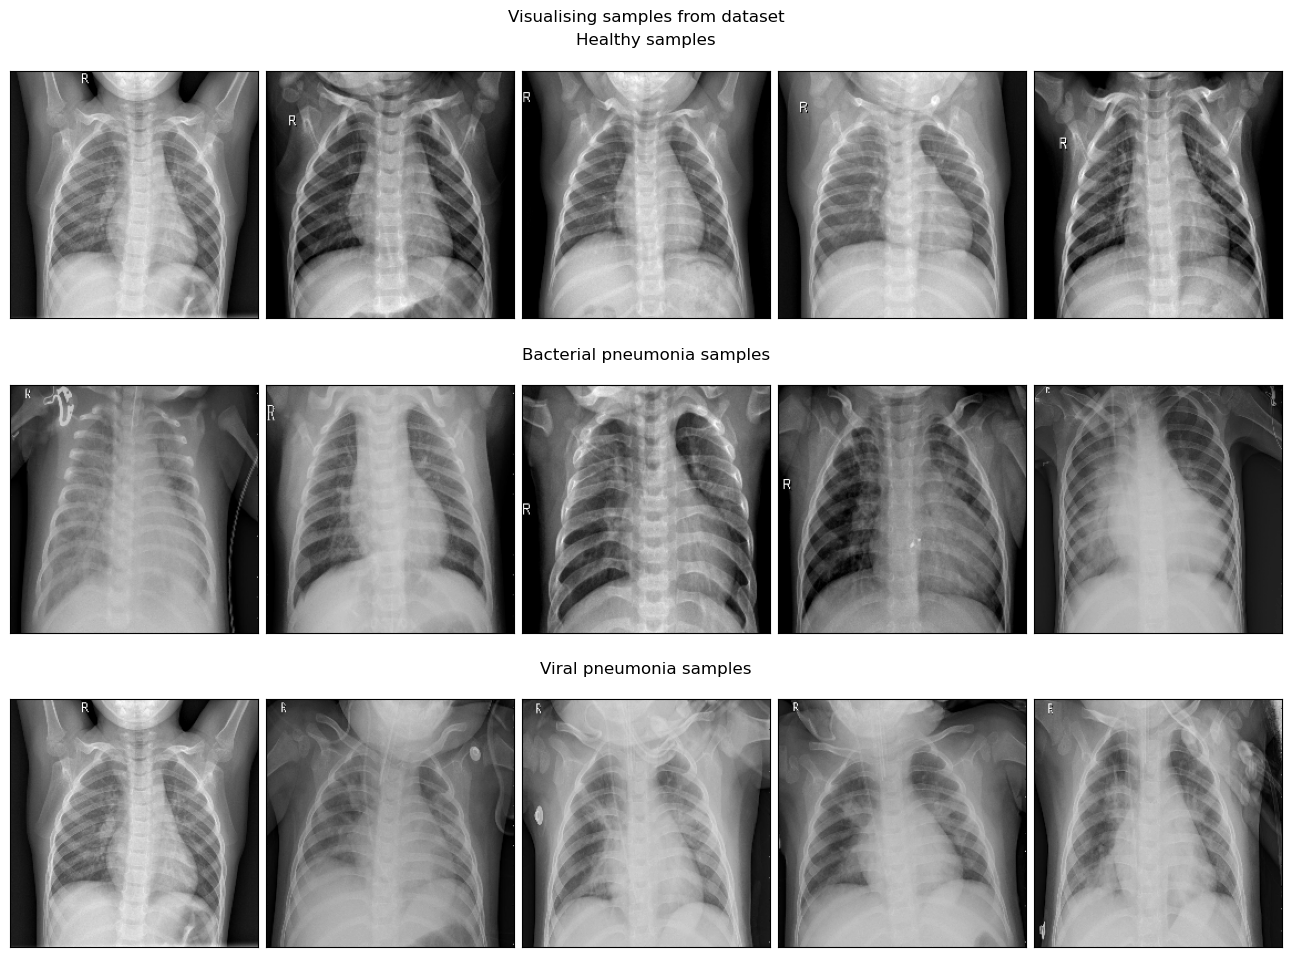

In [5]:
fig = plt.figure(constrained_layout=True, figsize=[12.8, 9.6])
fig.suptitle('Visualising samples from dataset')
subfigs = fig.subfigures(nrows=3, ncols=1)

subfigs[0].suptitle("Healthy samples")
axes = subfigs[0].subplots(nrows=1, ncols=5)
for i, ax in enumerate(axes):
    ax.imshow(train_dataset_orig[i][0][0], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

subfigs[1].suptitle("Bacterial pneumonia samples")
axes = subfigs[1].subplots(nrows=1, ncols=5)
for i, ax in enumerate(axes):
    ax.imshow(train_dataset_orig[1341+i][0][0], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

subfigs[2].suptitle("Viral pneumonia samples")
axes = subfigs[2].subplots(nrows=1, ncols=5)
for i, ax in enumerate(axes):
    ax.imshow(train_dataset_orig[-i][0][0], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

We can see some visual differences between healthy samples and samples with either type of pneumonia. We see that images of patients with pneumonia have regions which show up as dense in the images, whereas in healthy lungs, those areas are not dense. A difference between the images of lungs with viral and bacterial pneumonia is that in patients with bacterial pneumonia, the dense region is localised, whereas in images of lungs of people with viral pneumonia, the dense regions are present in multiple regions of the lungs.

In further analyses, we will not differentiate between different types of pneumonia.

### Visualising class counts

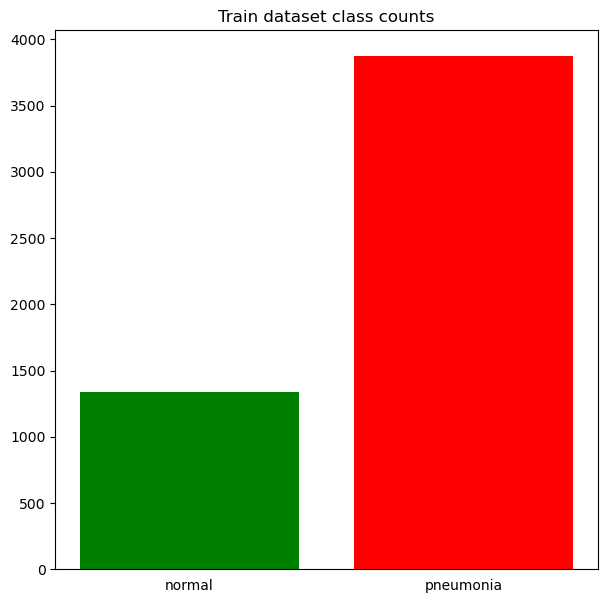

In [6]:
train_dataset_class_counts = [train_dataset_orig.labels.count(class_label) for class_label in range(2)]

plt.figure(figsize = (7,7))
plt.bar(["normal", "pneumonia"], train_dataset_class_counts, color=['green', 'red'])
plt.tick_params(bottom = False)
plt.title("Train dataset class counts")
print()

As one can see, the dataset is highly imbalanced, in the sense that there are more x ray images displaying signs of pneumonia, than there are healthy ones. This is perhaps due to the fact that in pneumonia detection, false positives might have less detrimental effects than false negatives. Since there is nevertheless a sufficient number of examples of normal lungs present, we do not try to explore options to address the class imbalance.

### Preprocessing
Preprocessing is done in the `PneumoniaDataset` class. Namely the preprocessing consists of reshaping the images so that all of them have the same size and shape. Namely, we decided to resize the images to size (224,224). Also, the luminosity values of the image are rescaled to the range [0,1] in order for the model to be able to learn more easily. Some images in the dataset are RGB images, whereas others are grayscale (single-channel) images. We decided to convert all images to grayscale.

# Model
As our cnn model for creating prediction, we use a simple model with 4 convolutional and 3 fully-connected layers. We also experimented with the smallest pre-trained resnet, but the model had too much capacity for the task at hand so we settled on the small model we defined ourselves. A detailed sketch of the model architecture is given in the accompanying report.

We decided to frame this problem as a 2-class classification problem. Therefore, our neural network outputs a single number in the range [0,1] where 0 corresponds to a healthy sample and 1 corresponds to pneumonia

In [7]:
model = SmallCNN()

### Training

We chose to train our model using the Adam optimizer. The loss function we used was binary cross-entropy loss. We chose not to use a learning rate scheduler, as the optimizer is adaptive and therefore not particularly sensitive to choice of learning rate. The batch size we used was 256. After each training epoch, we evaluate the performance of our model on the validation set. The metrics we use to measure the performance of our model are area under the ROC-curve, accuracy, precision, recall and F1 score. We trained our model for 30 epochs and after each epoch saved the model in case it was performing better than the previous best-performing model. As the final model, we choose the model that achieved the lowest binary cross-entropy loss on the validation dataset. As a tie-breaker metric in case of multiple models with the same loss, we use the area under the ROC-curve.

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_args = {
    "epochs": 30, 
    "device": device,
    "scheduler": "",
    "optimizer_args": { "lr": 0.0001},
    "verbose": True,
    "batch_size": 256
}

In [9]:
trainloader = DataLoader(train_dataset, train_args["batch_size"], shuffle=True)
valloader = DataLoader(val_dataset, train_args["batch_size"], shuffle=False)

In [11]:
results = train(model, trainloader, valloader, train_args)
model = results["model"]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 0 | 	 train loss:  0.0027, train roc auc: 0.5000, train accuracy: 0.7421, train precision: 0.7421, train recall: 1.0000, train f1 score: 0.8520 |               
	 val loss: 0.0038, val roc auc: 0.5000, val accuracy: 0.7424, val precision: 0.7424, val recall: 1.0000, val f1 score: 0.8521 


  3%|▎         | 1/30 [00:04<02:05,  4.34s/it]

Epoch 1 | 	 train loss:  0.0025, train roc auc: 0.5000, train accuracy: 0.7421, train precision: 0.7421, train recall: 1.0000, train f1 score: 0.8520 |               
	 val loss: 0.0036, val roc auc: 0.5000, val accuracy: 0.7424, val precision: 0.7424, val recall: 1.0000, val f1 score: 0.8521 


  7%|▋         | 2/30 [00:07<01:36,  3.45s/it]

Epoch 2 | 	 train loss:  0.0024, train roc auc: 0.5000, train accuracy: 0.7421, train precision: 0.7421, train recall: 1.0000, train f1 score: 0.8520 |               
	 val loss: 0.0036, val roc auc: 0.5000, val accuracy: 0.7424, val precision: 0.7424, val recall: 1.0000, val f1 score: 0.8521 


 10%|█         | 3/30 [00:09<01:24,  3.14s/it]

Epoch 3 | 	 train loss:  0.0023, train roc auc: 0.5000, train accuracy: 0.7421, train precision: 0.7421, train recall: 1.0000, train f1 score: 0.8520 |               
	 val loss: 0.0036, val roc auc: 0.5000, val accuracy: 0.7424, val precision: 0.7424, val recall: 1.0000, val f1 score: 0.8521 


 13%|█▎        | 4/30 [00:12<01:18,  3.01s/it]

Epoch 4 | 	 train loss:  0.0023, train roc auc: 0.5000, train accuracy: 0.7421, train precision: 0.7421, train recall: 1.0000, train f1 score: 0.8520 |               
	 val loss: 0.0036, val roc auc: 0.5000, val accuracy: 0.7424, val precision: 0.7424, val recall: 1.0000, val f1 score: 0.8521 


 17%|█▋        | 5/30 [00:15<01:13,  2.95s/it]

Epoch 5 | 	 train loss:  0.0023, train roc auc: 0.5000, train accuracy: 0.7421, train precision: 0.7421, train recall: 1.0000, train f1 score: 0.8520 |               
	 val loss: 0.0036, val roc auc: 0.5000, val accuracy: 0.7424, val precision: 0.7424, val recall: 1.0000, val f1 score: 0.8521 


 20%|██        | 6/30 [00:18<01:10,  2.94s/it]

Epoch 6 | 	 train loss:  0.0023, train roc auc: 0.5000, train accuracy: 0.7421, train precision: 0.7421, train recall: 1.0000, train f1 score: 0.8520 |               
	 val loss: 0.0036, val roc auc: 0.5000, val accuracy: 0.7424, val precision: 0.7424, val recall: 1.0000, val f1 score: 0.8521 


 23%|██▎       | 7/30 [00:21<01:06,  2.89s/it]

Epoch 7 | 	 train loss:  0.0022, train roc auc: 0.5000, train accuracy: 0.7421, train precision: 0.7421, train recall: 1.0000, train f1 score: 0.8520 |               
	 val loss: 0.0035, val roc auc: 0.5000, val accuracy: 0.7424, val precision: 0.7424, val recall: 1.0000, val f1 score: 0.8521 


 27%|██▋       | 8/30 [00:24<01:04,  2.95s/it]

Epoch 8 | 	 train loss:  0.0022, train roc auc: 0.5000, train accuracy: 0.7421, train precision: 0.7421, train recall: 1.0000, train f1 score: 0.8520 |               
	 val loss: 0.0034, val roc auc: 0.5000, val accuracy: 0.7424, val precision: 0.7424, val recall: 1.0000, val f1 score: 0.8521 


 30%|███       | 9/30 [00:27<01:02,  2.96s/it]

Epoch 9 | 	 train loss:  0.0021, train roc auc: 0.5000, train accuracy: 0.7421, train precision: 0.7421, train recall: 1.0000, train f1 score: 0.8520 |               
	 val loss: 0.0032, val roc auc: 0.5000, val accuracy: 0.7424, val precision: 0.7424, val recall: 1.0000, val f1 score: 0.8521 


 33%|███▎      | 10/30 [00:30<00:58,  2.93s/it]

Epoch 10 | 	 train loss:  0.0019, train roc auc: 0.5410, train accuracy: 0.7623, train precision: 0.7582, train recall: 0.9980, train f1 score: 0.8617 |               
	 val loss: 0.0029, val roc auc: 0.6503, val accuracy: 0.8111, val precision: 0.8059, val recall: 0.9820, val f1 score: 0.8853 


 37%|███▋      | 11/30 [00:33<00:54,  2.89s/it]

Epoch 11 | 	 train loss:  0.0016, train roc auc: 0.7134, train accuracy: 0.8339, train precision: 0.8380, train recall: 0.9622, train f1 score: 0.8958 |               
	 val loss: 0.0025, val roc auc: 0.7704, val accuracy: 0.8531, val precision: 0.8714, val recall: 0.9409, val f1 score: 0.9048 


 40%|████      | 12/30 [00:35<00:51,  2.88s/it]

Epoch 12 | 	 train loss:  0.0013, train roc auc: 0.7955, train accuracy: 0.8687, train precision: 0.8845, train recall: 0.9468, train f1 score: 0.9146 |               
	 val loss: 0.0021, val roc auc: 0.8126, val accuracy: 0.8798, val precision: 0.8937, val recall: 0.9512, val f1 score: 0.9215 


 43%|████▎     | 13/30 [00:38<00:48,  2.88s/it]

Epoch 13 | 	 train loss:  0.0011, train roc auc: 0.8293, train accuracy: 0.8834, train precision: 0.9055, train recall: 0.9410, train f1 score: 0.9229 |               
	 val loss: 0.0017, val roc auc: 0.8654, val accuracy: 0.9008, val precision: 0.9288, val recall: 0.9383, val f1 score: 0.9335 


 47%|████▋     | 14/30 [00:41<00:46,  2.88s/it]

Epoch 14 | 	 train loss:  0.0009, train roc auc: 0.8624, train accuracy: 0.9019, train precision: 0.9254, train recall: 0.9439, train f1 score: 0.9345 |               
	 val loss: 0.0015, val roc auc: 0.8939, val accuracy: 0.9179, val precision: 0.9459, val recall: 0.9434, val f1 score: 0.9447 


 50%|█████     | 15/30 [00:44<00:43,  2.87s/it]

Epoch 15 | 	 train loss:  0.0008, train roc auc: 0.8751, train accuracy: 0.9099, train precision: 0.9326, train recall: 0.9471, train f1 score: 0.9398 |               
	 val loss: 0.0018, val roc auc: 0.8240, val accuracy: 0.8931, val precision: 0.8974, val recall: 0.9666, val f1 score: 0.9307 


 53%|█████▎    | 16/30 [00:47<00:40,  2.88s/it]

Epoch 16 | 	 train loss:  0.0009, train roc auc: 0.8742, train accuracy: 0.9070, train precision: 0.9334, train recall: 0.9419, train f1 score: 0.9376 |               
	 val loss: 0.0020, val roc auc: 0.7797, val accuracy: 0.8740, val precision: 0.8713, val recall: 0.9743, val f1 score: 0.9199 


 57%|█████▋    | 17/30 [00:50<00:37,  2.90s/it]

Epoch 17 | 	 train loss:  0.0008, train roc auc: 0.8778, train accuracy: 0.9148, train precision: 0.9326, train recall: 0.9542, train f1 score: 0.9433 |               
	 val loss: 0.0012, val roc auc: 0.9162, val accuracy: 0.9294, val precision: 0.9607, val recall: 0.9434, val f1 score: 0.9520 


 60%|██████    | 18/30 [00:53<00:35,  2.92s/it]

Epoch 18 | 	 train loss:  0.0007, train roc auc: 0.8947, train accuracy: 0.9223, train precision: 0.9441, train recall: 0.9516, train f1 score: 0.9478 |               
	 val loss: 0.0015, val roc auc: 0.8624, val accuracy: 0.9141, val precision: 0.9195, val recall: 0.9692, val f1 score: 0.9437 


 63%|██████▎   | 19/30 [00:57<00:35,  3.24s/it]

Epoch 19 | 	 train loss:  0.0007, train roc auc: 0.8936, train accuracy: 0.9223, train precision: 0.9431, train recall: 0.9528, train f1 score: 0.9479 |               
	 val loss: 0.0011, val roc auc: 0.9004, val accuracy: 0.9275, val precision: 0.9466, val recall: 0.9563, val f1 score: 0.9514 


 67%|██████▋   | 20/30 [01:10<01:03,  6.35s/it]

Epoch 20 | 	 train loss:  0.0007, train roc auc: 0.9015, train accuracy: 0.9288, train precision: 0.9468, train recall: 0.9579, train f1 score: 0.9523 |               
	 val loss: 0.0012, val roc auc: 0.9002, val accuracy: 0.9237, val precision: 0.9486, val recall: 0.9486, val f1 score: 0.9486 


 70%|███████   | 21/30 [01:24<01:17,  8.59s/it]

Epoch 21 | 	 train loss:  0.0007, train roc auc: 0.9079, train accuracy: 0.9331, train precision: 0.9504, train recall: 0.9599, train f1 score: 0.9551 |               
	 val loss: 0.0011, val roc auc: 0.9405, val accuracy: 0.9332, val precision: 0.9836, val recall: 0.9254, val f1 score: 0.9536 


 73%|███████▎  | 22/30 [01:39<01:22, 10.35s/it]

Epoch 22 | 	 train loss:  0.0007, train roc auc: 0.9090, train accuracy: 0.9303, train precision: 0.9531, train recall: 0.9531, train f1 score: 0.9531 |               
	 val loss: 0.0013, val roc auc: 0.8699, val accuracy: 0.9218, val precision: 0.9223, val recall: 0.9769, val f1 score: 0.9488 


 77%|███████▋  | 23/30 [01:53<01:21, 11.60s/it]

Epoch 23 | 	 train loss:  0.0007, train roc auc: 0.9031, train accuracy: 0.9316, train precision: 0.9468, train recall: 0.9619, train f1 score: 0.9543 |               
	 val loss: 0.0011, val roc auc: 0.9442, val accuracy: 0.9351, val precision: 0.9863, val recall: 0.9254, val f1 score: 0.9549 


 80%|████████  | 24/30 [02:07<01:13, 12.29s/it]

Epoch 24 | 	 train loss:  0.0006, train roc auc: 0.9143, train accuracy: 0.9359, train precision: 0.9550, train recall: 0.9588, train f1 score: 0.9569 |               
	 val loss: 0.0010, val roc auc: 0.9213, val accuracy: 0.9370, val precision: 0.9611, val recall: 0.9537, val f1 score: 0.9574 


 83%|████████▎ | 25/30 [02:21<01:03, 12.75s/it]

Epoch 25 | 	 train loss:  0.0006, train roc auc: 0.9099, train accuracy: 0.9352, train precision: 0.9511, train recall: 0.9622, train f1 score: 0.9566 |               
	 val loss: 0.0011, val roc auc: 0.9478, val accuracy: 0.9332, val precision: 0.9917, val recall: 0.9177, val f1 score: 0.9533 


 87%|████████▋ | 26/30 [02:35<00:52, 13.07s/it]

Epoch 26 | 	 train loss:  0.0007, train roc auc: 0.9123, train accuracy: 0.9297, train precision: 0.9567, train recall: 0.9482, train f1 score: 0.9524 |               
	 val loss: 0.0010, val roc auc: 0.9168, val accuracy: 0.9447, val precision: 0.9523, val recall: 0.9743, val f1 score: 0.9632 


 90%|█████████ | 27/30 [02:49<00:39, 13.29s/it]

Epoch 27 | 	 train loss:  0.0006, train roc auc: 0.9174, train accuracy: 0.9397, train precision: 0.9557, train recall: 0.9634, train f1 score: 0.9595 |               
	 val loss: 0.0009, val roc auc: 0.9290, val accuracy: 0.9485, val precision: 0.9617, val recall: 0.9692, val f1 score: 0.9654 


 93%|█████████▎| 28/30 [03:02<00:26, 13.44s/it]

Epoch 28 | 	 train loss:  0.0006, train roc auc: 0.9300, train accuracy: 0.9456, train precision: 0.9644, train recall: 0.9622, train f1 score: 0.9633 |               
	 val loss: 0.0009, val roc auc: 0.9205, val accuracy: 0.9466, val precision: 0.9547, val recall: 0.9743, val f1 score: 0.9644 


 97%|█████████▋| 29/30 [03:16<00:13, 13.54s/it]

Epoch 29 | 	 train loss:  0.0006, train roc auc: 0.9296, train accuracy: 0.9473, train precision: 0.9629, train recall: 0.9662, train f1 score: 0.9646 |               
	 val loss: 0.0009, val roc auc: 0.9410, val accuracy: 0.9447, val precision: 0.9762, val recall: 0.9486, val f1 score: 0.9622 


100%|██████████| 30/30 [03:30<00:00,  7.01s/it]

Best model 23 tensor(0.0011, device='cuda:0') 0.9442064172141293


### Evaluation on test dataset

In [13]:
from train_utils import validate
test_dataset = PneumoniaDataset("data/chest_xray/test", resize_transform, use_rgb=False)
testloader = DataLoader(test_dataset, batch_size=train_args["batch_size"], shuffle=False)

/home/lrabuzin/.conda/envs/ML4HC/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [24]:
test_stats = validate(results["model"], testloader, train_args)
print(f"Test results -> \narea under the ROC-curve: {test_stats[1]:.2f},\naccuracy: {test_stats[2]:.2f},\nprecision: {test_stats[3]:.2f},\nrecall:{test_stats[4]:.2f},\nf1: {test_stats[5]:.2f}")

Test results -> 
area under the ROC-curve: 0.81,
accuracy: 0.84,
precision: 0.83,
recall:0.95,
f1: 0.88


# Integrated gradients

Integrated gradients is a method of attributing the prediction of a deep network to its input features, as an attempt towards explaining individual predictions. As a baseline, we use the zero-image (i.e. all-black image), since it represents the absence of signal. In the visualizations that we rendered, the regions highlighted green correspond to positive attributions (i.e. these regions contribute to the model predicting that a person has pneumonia), while the red regions correspond to negative attributions (i.e. these regions contribute to the model predicting that a person is healthy).

In [15]:
def integrated_gradients(model, input, n_iter):
    """
    Expects batched input a.k.a. input of shape (1, 1, H, W)
    """
    model.cpu()
    model.eval()
    baseline = torch.zeros(input.shape)
    input = input.requires_grad_()
    gradient_sum = torch.zeros(input.shape)
    for k in range(1, n_iter+1):
        model.zero_grad()
        kth_path_image = baseline + k/n_iter * (input - baseline)
        output = model(kth_path_image)
        gradients = torch.autograd.grad(outputs=output, inputs=input, retain_graph=True)[0]
        gradient_sum += gradients
    return (input - baseline) * gradient_sum * (1/n_iter)

In [16]:
def visualise_attribution_map(attribution, input, attribution_mul = 0.7, input_mul = 0.3):

    root_img = input[0].detach().permute([1,2,0]).numpy()

    ig = attribution[0]
    green_mask = ig > 0
    red_mask = ig < 0
    green = torch.clone(ig).detach()
    red = torch.clone(ig).detach()
    green[red_mask] = 0
    red[green_mask] = 0

    green = green[0]
    red = red[0]

    red = torch.abs(red)

    max_val = max(green.max(), red.max())

    green = green/max_val
    red = red/max_val
    blue = torch.zeros(red.shape)

    color_mask = torch.stack([red, green, blue])

    return attribution_mul*color_mask.permute([1,2,0]).numpy() + input_mul*root_img


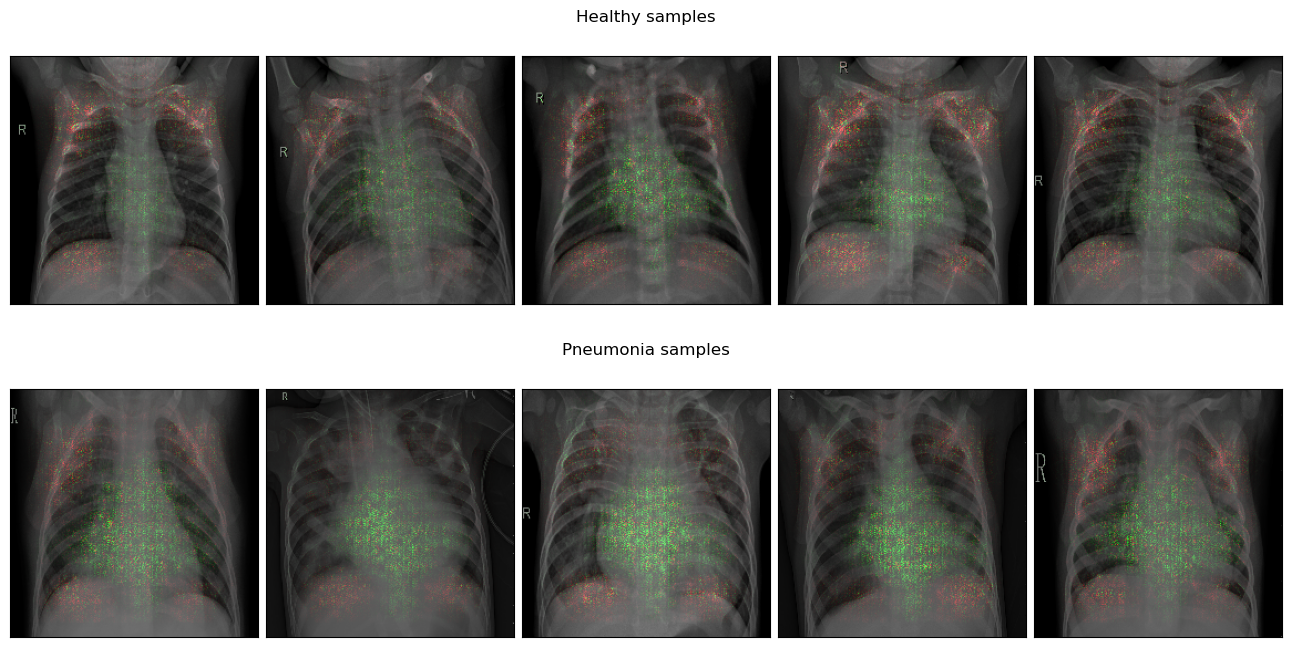

In [62]:
%%capture --no-display

fig = plt.figure(constrained_layout=True, figsize=[12.8, 6.6])
# fig.suptitle('Explaining outputs of model with integrated gradients')
subfigs = fig.subfigures(nrows=2, ncols=1)

offset = 20

subfigs[0].suptitle("Healthy samples")
axes = subfigs[0].subplots(nrows=1, ncols=5)
for i, ax in enumerate(axes):
    input = train_dataset_orig[i+offset][0].unsqueeze(0).requires_grad_(True)
    attribution = integrated_gradients(model, input, 500)
    ax.imshow(visualise_attribution_map(attribution, input, 1, 0.5))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

subfigs[1].suptitle("Pneumonia samples")
axes = subfigs[1].subplots(nrows=1, ncols=5)
for i, ax in enumerate(axes):
    input = train_dataset_orig[-(i+offset+1)][0].unsqueeze(0).requires_grad_(True)
    attribution = integrated_gradients(model, input, 500)
    ax.imshow(visualise_attribution_map(attribution, input, 1, 0.5))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()


We can see that there are clear visual differences between the attribution maps of healthy and diseased samples. In all samples, the middle region of the image is deemed as contributing to a positive pneumonia prediction. However, the positive signals are much larger and higher-intensity in the case of the model predicting that an image corresponds to a person with pneumonia. Furthermore, the areas highlighted green in the photos with pneumonia are the areas which exhibit an abnormal density in the scan, compared to the healthy samples. Curiously, in both the healthy and unhealthy samples, the model seems to identify negative signal in the upper and lower corners of the images, which doesn't seem to match our biological intuition of how the model is supposed to make predictions.

# Grad-cam

Grad-CAM uses the gradient information flowing into the last convolutional layer of the CNN to assign importance values to each neuron for a particular decision of interest. In our case, we visualise the gradient information flowing into the last convolutional layer of our CNN with respect to predicting that the image corresponds to pneumonia.

In [19]:
from matplotlib import cm
import numpy as np
from skimage.transform import resize
def gradCam(model, input):
    """
    Expects batched input a.k.a. input of shape (1, 1, H, W)
    """
    model.cpu()
    model.eval()
    model.zero_grad()
    input = input.requires_grad_()

    output = model(input)
    grad = torch.autograd.grad(outputs=output, inputs=model.last_conv, retain_graph=True)[0]
    pooled_grad = torch.mean(grad, dim=[0, 2, 3])
    activations = torch.clone(model.last_conv)
    for i in range(pooled_grad.shape[0]):
        activations[:, i, :, :] *= pooled_grad[i]
    attributions = torch.mean(activations, dim=1).squeeze()
    attributions = torch.nn.functional.relu(attributions)
    return attributions

In [92]:
def visualise_gradCam(attributions, input):
    normalised_attributions = (attributions/(torch.max(attributions)+1e-30)).detach().numpy()
    attribution_colors_ = cm.magma(normalised_attributions)
    attribution_colors = resize(attribution_colors_, (224,224), order=0)
    input_colors = cm.gray(input[0][0].detach().numpy())
    return 0.4*attribution_colors + 0.6*input_colors

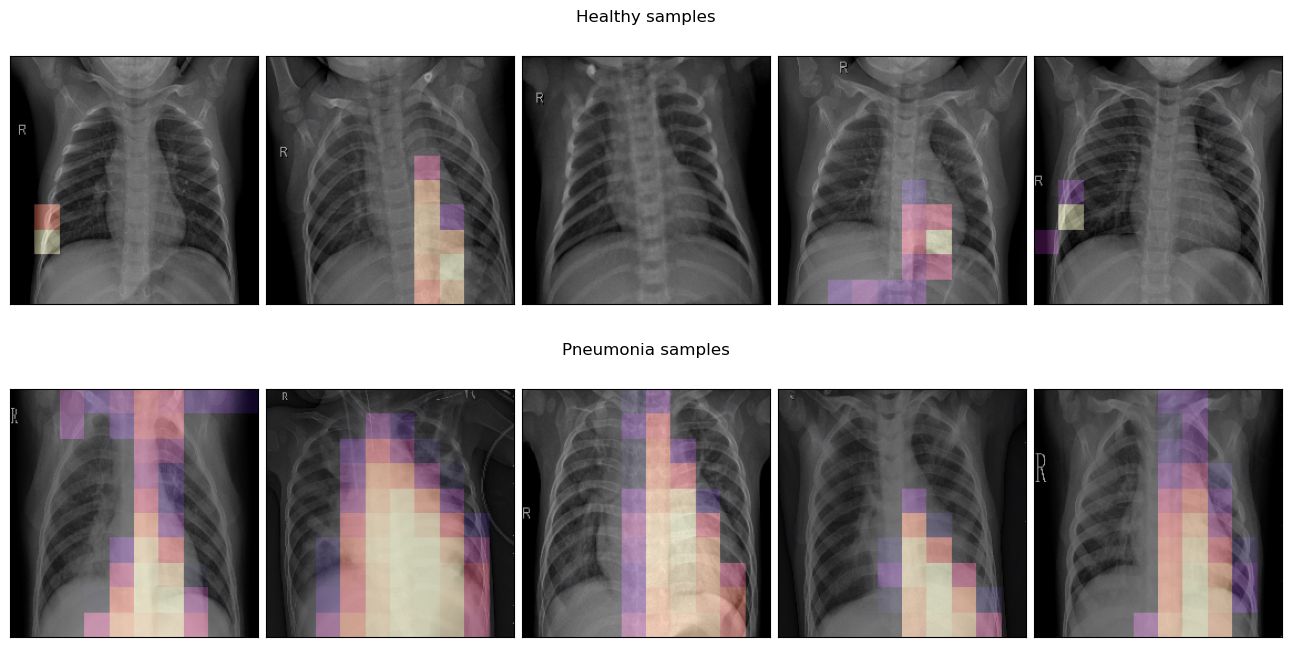

In [93]:
%%capture --no-display

fig = plt.figure(constrained_layout=True, figsize=[12.8, 6.6])
# fig.suptitle('Explaining outputs of model with GradCAM')
subfigs = fig.subfigures(nrows=2, ncols=1)

offset = 20

subfigs[0].suptitle("Healthy samples")
axes = subfigs[0].subplots(nrows=1, ncols=5)
for i, ax in enumerate(axes):
    input = train_dataset_orig[i+offset][0].unsqueeze(0).requires_grad_(True)
    attribution = gradCam(model, input)
    ax.imshow(visualise_gradCam(attribution, input))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

subfigs[1].suptitle("Pneumonia samples")
axes = subfigs[1].subplots(nrows=1, ncols=5)
for i, ax in enumerate(axes):
    input = train_dataset_orig[-(i+offset+1)][0].unsqueeze(0).requires_grad_(True)
    attribution = gradCam(model, input)
    ax.imshow(visualise_gradCam(attribution, input))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

Since we predict the gradient information flowing into the last convolutional layer, the GradCAM attribution maps we get are very coarse (10x10). We upscale the attribution maps we get with GradCAM and overla them over the input images. A clear trend that emerges here is that the support for pneumonia in attribution maps of healthy images is almost non-existent. For images wih pneumonia on the other hand, the support for pneumonia in the attribution maps is both very large and very intense. The regions the model focuses on also seem to match our biological intuition. The model seems to focus on regions with increased density in the scan. Attributions seem to be consistent across samples.

Compared to Integrated gradients, GradCam can't highlight negative contributions, but seems to show a much clearer trend when differentiating between healthy and unhealthy samples. Both methods seem to highlight sensible regions. GradCAM also offers more coarse attribution maps, but both methods seem to mostly agree on which regions of the image are responsible for the model predicting pneumonia.

# Data Randomization Test

In [94]:
from random import shuffle

In [95]:
permuted_model = SmallCNN()

In [ ]:
permuted_train_ds = PneumoniaDataset("data/chest_xray/train", resize_transform, use_rgb=False)
permuted_val_ds = PneumoniaDataset("data/chest_xray/val", resize_transform, use_rgb=False)
permuted_test_ds = PneumoniaDataset("data/chest_xray/test", resize_transform, use_rgb=False)

shuffle(permuted_train_ds.labels)
shuffle(permuted_val_ds.labels)
shuffle(permuted_test_ds.labels)

In [98]:
permuted_trainloader = DataLoader(permuted_train_ds, train_args["batch_size"], shuffle=True)
permuted_valloader = DataLoader(permuted_val_ds, train_args["batch_size"], shuffle=False)

In [99]:
permuted_train_args = {
    "epochs": 30, 
    "device": device,
    "scheduler": "",
    "optimizer_args": { "lr": 0.0001},
    "verbose": True,
    "batch_size": 256
}

In [100]:
permuted_results = train(permuted_model, permuted_trainloader, permuted_valloader, permuted_train_args, take_last_model=True)
permuted_model = permuted_results["model"]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 0 | 	 train loss:  0.0028, train roc auc: 0.5007, train accuracy: 0.5936, train precision: 0.7433, train recall: 0.6919, train f1 score: 0.7167 |               
	 val loss: 0.0435, val roc auc: 0.5000, val accuracy: 0.5000, val precision: 0.5000, val recall: 1.0000, val f1 score: 0.6667 


  3%|▎         | 1/30 [00:02<01:25,  2.94s/it]

Epoch 1 | 	 train loss:  0.0025, train roc auc: 0.5000, train accuracy: 0.7429, train precision: 0.7429, train recall: 1.0000, train f1 score: 0.8525 |               
	 val loss: 0.0543, val roc auc: 0.5000, val accuracy: 0.5000, val precision: 0.5000, val recall: 1.0000, val f1 score: 0.6667 


  7%|▋         | 2/30 [00:05<01:20,  2.89s/it]

Epoch 2 | 	 train loss:  0.0023, train roc auc: 0.5000, train accuracy: 0.7429, train precision: 0.7429, train recall: 1.0000, train f1 score: 0.8525 |               
	 val loss: 0.0506, val roc auc: 0.5000, val accuracy: 0.5000, val precision: 0.5000, val recall: 1.0000, val f1 score: 0.6667 


 10%|█         | 3/30 [00:08<01:17,  2.86s/it]

Epoch 3 | 	 train loss:  0.0023, train roc auc: 0.5000, train accuracy: 0.7429, train precision: 0.7429, train recall: 1.0000, train f1 score: 0.8525 |               
	 val loss: 0.0515, val roc auc: 0.5000, val accuracy: 0.5000, val precision: 0.5000, val recall: 1.0000, val f1 score: 0.6667 


 13%|█▎        | 4/30 [00:11<01:14,  2.86s/it]

Epoch 4 | 	 train loss:  0.0023, train roc auc: 0.5000, train accuracy: 0.7429, train precision: 0.7429, train recall: 1.0000, train f1 score: 0.8525 |               
	 val loss: 0.0518, val roc auc: 0.5000, val accuracy: 0.5000, val precision: 0.5000, val recall: 1.0000, val f1 score: 0.6667 


 17%|█▋        | 5/30 [00:14<01:11,  2.88s/it]

Epoch 5 | 	 train loss:  0.0023, train roc auc: 0.5000, train accuracy: 0.7429, train precision: 0.7429, train recall: 1.0000, train f1 score: 0.8525 |               
	 val loss: 0.0520, val roc auc: 0.5000, val accuracy: 0.5000, val precision: 0.5000, val recall: 1.0000, val f1 score: 0.6667 


 20%|██        | 6/30 [00:17<01:09,  2.88s/it]

Epoch 6 | 	 train loss:  0.0023, train roc auc: 0.5000, train accuracy: 0.7429, train precision: 0.7429, train recall: 1.0000, train f1 score: 0.8525 |               
	 val loss: 0.0521, val roc auc: 0.5000, val accuracy: 0.5000, val precision: 0.5000, val recall: 1.0000, val f1 score: 0.6667 


 23%|██▎       | 7/30 [00:20<01:06,  2.90s/it]

Epoch 7 | 	 train loss:  0.0023, train roc auc: 0.5000, train accuracy: 0.7429, train precision: 0.7429, train recall: 1.0000, train f1 score: 0.8525 |               
	 val loss: 0.0525, val roc auc: 0.5000, val accuracy: 0.5000, val precision: 0.5000, val recall: 1.0000, val f1 score: 0.6667 


 27%|██▋       | 8/30 [00:23<01:03,  2.90s/it]

Epoch 8 | 	 train loss:  0.0023, train roc auc: 0.5000, train accuracy: 0.7429, train precision: 0.7429, train recall: 1.0000, train f1 score: 0.8525 |               
	 val loss: 0.0524, val roc auc: 0.5000, val accuracy: 0.5000, val precision: 0.5000, val recall: 1.0000, val f1 score: 0.6667 


 30%|███       | 9/30 [00:25<01:00,  2.89s/it]

Epoch 9 | 	 train loss:  0.0023, train roc auc: 0.5000, train accuracy: 0.7429, train precision: 0.7429, train recall: 1.0000, train f1 score: 0.8525 |               
	 val loss: 0.0520, val roc auc: 0.5000, val accuracy: 0.5000, val precision: 0.5000, val recall: 1.0000, val f1 score: 0.6667 


 33%|███▎      | 10/30 [00:28<00:57,  2.86s/it]

Epoch 10 | 	 train loss:  0.0023, train roc auc: 0.5000, train accuracy: 0.7429, train precision: 0.7429, train recall: 1.0000, train f1 score: 0.8525 |               
	 val loss: 0.0525, val roc auc: 0.5000, val accuracy: 0.5000, val precision: 0.5000, val recall: 1.0000, val f1 score: 0.6667 


 37%|███▋      | 11/30 [00:31<00:54,  2.84s/it]

Epoch 11 | 	 train loss:  0.0023, train roc auc: 0.5000, train accuracy: 0.7429, train precision: 0.7429, train recall: 1.0000, train f1 score: 0.8525 |               
	 val loss: 0.0522, val roc auc: 0.5000, val accuracy: 0.5000, val precision: 0.5000, val recall: 1.0000, val f1 score: 0.6667 


 40%|████      | 12/30 [00:34<00:50,  2.83s/it]

Epoch 12 | 	 train loss:  0.0023, train roc auc: 0.5000, train accuracy: 0.7429, train precision: 0.7429, train recall: 1.0000, train f1 score: 0.8525 |               
	 val loss: 0.0513, val roc auc: 0.5000, val accuracy: 0.5000, val precision: 0.5000, val recall: 1.0000, val f1 score: 0.6667 


 43%|████▎     | 13/30 [00:37<00:48,  2.87s/it]

Epoch 13 | 	 train loss:  0.0023, train roc auc: 0.5000, train accuracy: 0.7429, train precision: 0.7429, train recall: 1.0000, train f1 score: 0.8525 |               
	 val loss: 0.0541, val roc auc: 0.5000, val accuracy: 0.5000, val precision: 0.5000, val recall: 1.0000, val f1 score: 0.6667 


 47%|████▋     | 14/30 [00:40<00:46,  2.90s/it]

Epoch 14 | 	 train loss:  0.0023, train roc auc: 0.5000, train accuracy: 0.7429, train precision: 0.7429, train recall: 1.0000, train f1 score: 0.8525 |               
	 val loss: 0.0508, val roc auc: 0.5000, val accuracy: 0.5000, val precision: 0.5000, val recall: 1.0000, val f1 score: 0.6667 


 50%|█████     | 15/30 [00:43<00:43,  2.91s/it]

Epoch 15 | 	 train loss:  0.0023, train roc auc: 0.5000, train accuracy: 0.7429, train precision: 0.7429, train recall: 1.0000, train f1 score: 0.8525 |               
	 val loss: 0.0528, val roc auc: 0.5000, val accuracy: 0.5000, val precision: 0.5000, val recall: 1.0000, val f1 score: 0.6667 


 53%|█████▎    | 16/30 [00:46<00:40,  2.93s/it]

Epoch 16 | 	 train loss:  0.0023, train roc auc: 0.5000, train accuracy: 0.7429, train precision: 0.7429, train recall: 1.0000, train f1 score: 0.8525 |               
	 val loss: 0.0508, val roc auc: 0.5000, val accuracy: 0.5000, val precision: 0.5000, val recall: 1.0000, val f1 score: 0.6667 


 57%|█████▋    | 17/30 [00:49<00:38,  2.98s/it]

Epoch 17 | 	 train loss:  0.0023, train roc auc: 0.5000, train accuracy: 0.7429, train precision: 0.7429, train recall: 1.0000, train f1 score: 0.8525 |               
	 val loss: 0.0521, val roc auc: 0.5000, val accuracy: 0.5000, val precision: 0.5000, val recall: 1.0000, val f1 score: 0.6667 


 60%|██████    | 18/30 [00:52<00:35,  2.98s/it]

Epoch 18 | 	 train loss:  0.0023, train roc auc: 0.5000, train accuracy: 0.7429, train precision: 0.7429, train recall: 1.0000, train f1 score: 0.8525 |               
	 val loss: 0.0521, val roc auc: 0.5000, val accuracy: 0.5000, val precision: 0.5000, val recall: 1.0000, val f1 score: 0.6667 


 63%|██████▎   | 19/30 [00:55<00:33,  3.02s/it]

Epoch 19 | 	 train loss:  0.0023, train roc auc: 0.5000, train accuracy: 0.7429, train precision: 0.7429, train recall: 1.0000, train f1 score: 0.8525 |               
	 val loss: 0.0527, val roc auc: 0.5000, val accuracy: 0.5000, val precision: 0.5000, val recall: 1.0000, val f1 score: 0.6667 


 67%|██████▋   | 20/30 [00:58<00:30,  3.02s/it]

Epoch 20 | 	 train loss:  0.0023, train roc auc: 0.5000, train accuracy: 0.7429, train precision: 0.7429, train recall: 1.0000, train f1 score: 0.8525 |               
	 val loss: 0.0495, val roc auc: 0.5000, val accuracy: 0.5000, val precision: 0.5000, val recall: 1.0000, val f1 score: 0.6667 


 70%|███████   | 21/30 [01:01<00:27,  3.01s/it]

Epoch 21 | 	 train loss:  0.0023, train roc auc: 0.5000, train accuracy: 0.7429, train precision: 0.7429, train recall: 1.0000, train f1 score: 0.8525 |               
	 val loss: 0.0507, val roc auc: 0.5000, val accuracy: 0.5000, val precision: 0.5000, val recall: 1.0000, val f1 score: 0.6667 


 73%|███████▎  | 22/30 [01:04<00:24,  3.01s/it]

Epoch 22 | 	 train loss:  0.0023, train roc auc: 0.5000, train accuracy: 0.7429, train precision: 0.7429, train recall: 1.0000, train f1 score: 0.8525 |               
	 val loss: 0.0524, val roc auc: 0.5000, val accuracy: 0.5000, val precision: 0.5000, val recall: 1.0000, val f1 score: 0.6667 


 77%|███████▋  | 23/30 [01:07<00:21,  3.01s/it]

Epoch 23 | 	 train loss:  0.0023, train roc auc: 0.5000, train accuracy: 0.7429, train precision: 0.7429, train recall: 1.0000, train f1 score: 0.8525 |               
	 val loss: 0.0523, val roc auc: 0.5000, val accuracy: 0.5000, val precision: 0.5000, val recall: 1.0000, val f1 score: 0.6667 


 80%|████████  | 24/30 [01:10<00:17,  2.99s/it]

Epoch 24 | 	 train loss:  0.0023, train roc auc: 0.5000, train accuracy: 0.7429, train precision: 0.7429, train recall: 1.0000, train f1 score: 0.8525 |               
	 val loss: 0.0511, val roc auc: 0.5000, val accuracy: 0.5000, val precision: 0.5000, val recall: 1.0000, val f1 score: 0.6667 


 83%|████████▎ | 25/30 [01:13<00:14,  2.98s/it]

Epoch 25 | 	 train loss:  0.0023, train roc auc: 0.5000, train accuracy: 0.7429, train precision: 0.7429, train recall: 1.0000, train f1 score: 0.8525 |               
	 val loss: 0.0526, val roc auc: 0.5000, val accuracy: 0.5000, val precision: 0.5000, val recall: 1.0000, val f1 score: 0.6667 


 87%|████████▋ | 26/30 [01:16<00:11,  2.96s/it]

Epoch 26 | 	 train loss:  0.0023, train roc auc: 0.5000, train accuracy: 0.7429, train precision: 0.7429, train recall: 1.0000, train f1 score: 0.8525 |               
	 val loss: 0.0513, val roc auc: 0.5000, val accuracy: 0.5000, val precision: 0.5000, val recall: 1.0000, val f1 score: 0.6667 


 90%|█████████ | 27/30 [01:19<00:08,  2.99s/it]

Epoch 27 | 	 train loss:  0.0023, train roc auc: 0.5000, train accuracy: 0.7429, train precision: 0.7429, train recall: 1.0000, train f1 score: 0.8525 |               
	 val loss: 0.0521, val roc auc: 0.5000, val accuracy: 0.5000, val precision: 0.5000, val recall: 1.0000, val f1 score: 0.6667 


 93%|█████████▎| 28/30 [01:22<00:05,  2.97s/it]

Epoch 28 | 	 train loss:  0.0023, train roc auc: 0.5000, train accuracy: 0.7429, train precision: 0.7429, train recall: 1.0000, train f1 score: 0.8525 |               
	 val loss: 0.0521, val roc auc: 0.5000, val accuracy: 0.5000, val precision: 0.5000, val recall: 1.0000, val f1 score: 0.6667 


 97%|█████████▋| 29/30 [01:25<00:02,  2.96s/it]

Epoch 29 | 	 train loss:  0.0023, train roc auc: 0.5000, train accuracy: 0.7429, train precision: 0.7429, train recall: 1.0000, train f1 score: 0.8525 |               
	 val loss: 0.0522, val roc auc: 0.5000, val accuracy: 0.5000, val precision: 0.5000, val recall: 1.0000, val f1 score: 0.6667 


100%|██████████| 30/30 [01:28<00:00,  2.94s/it]

Best model 29 tensor(0.0522, device='cuda:0') 0.5


### Integrated Gradients attribution maps of the model trained on permuted data

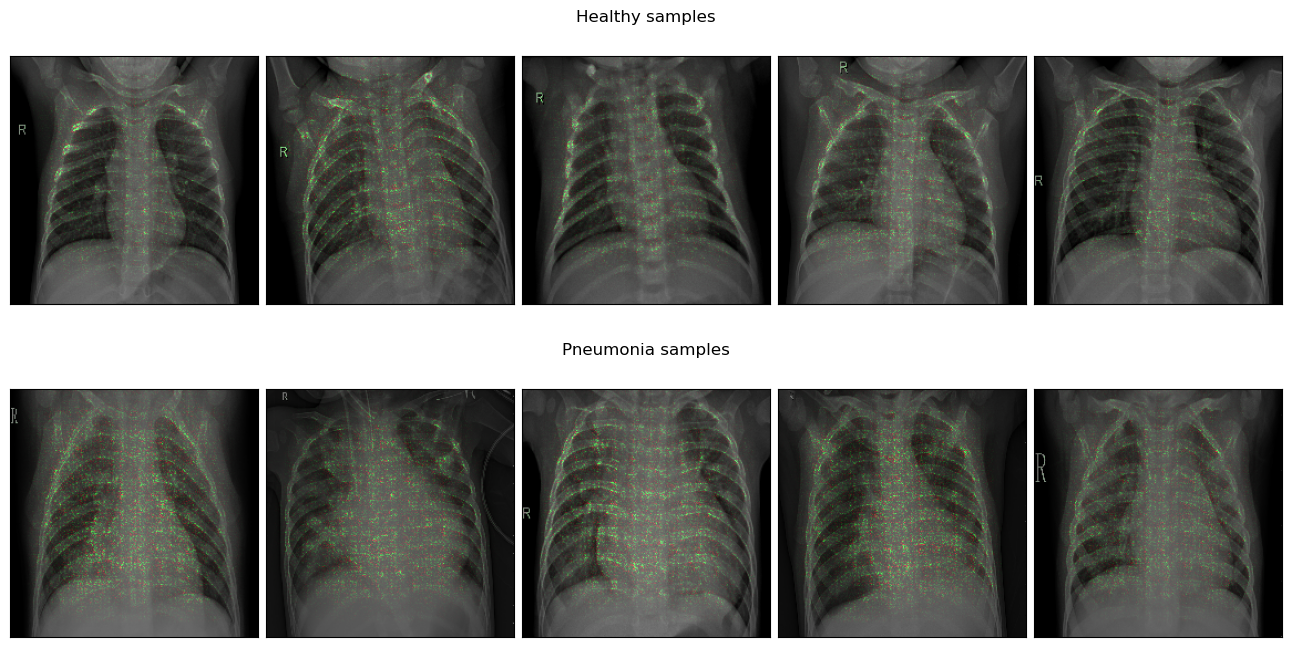

In [102]:
%%capture --no-display

fig = plt.figure(constrained_layout=True, figsize=[12.8, 6.6])
# fig.suptitle('Explaining outputs of model with integrated gradients')
subfigs = fig.subfigures(nrows=2, ncols=1)

offset = 20

subfigs[0].suptitle("Healthy samples")
axes = subfigs[0].subplots(nrows=1, ncols=5)
for i, ax in enumerate(axes):
    input = train_dataset_orig[i+offset][0].unsqueeze(0).requires_grad_(True)
    attribution = integrated_gradients(permuted_model, input, 500)
    ax.imshow(visualise_attribution_map(attribution, input, 1, 0.5))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

subfigs[1].suptitle("Pneumonia samples")
axes = subfigs[1].subplots(nrows=1, ncols=5)
for i, ax in enumerate(axes):
    input = train_dataset_orig[-(i+offset+1)][0].unsqueeze(0).requires_grad_(True)
    attribution = integrated_gradients(permuted_model, input, 500)
    ax.imshow(visualise_attribution_map(attribution, input, 1, 0.5))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()


### GradCAM attribution maps of the model trained on permuted data

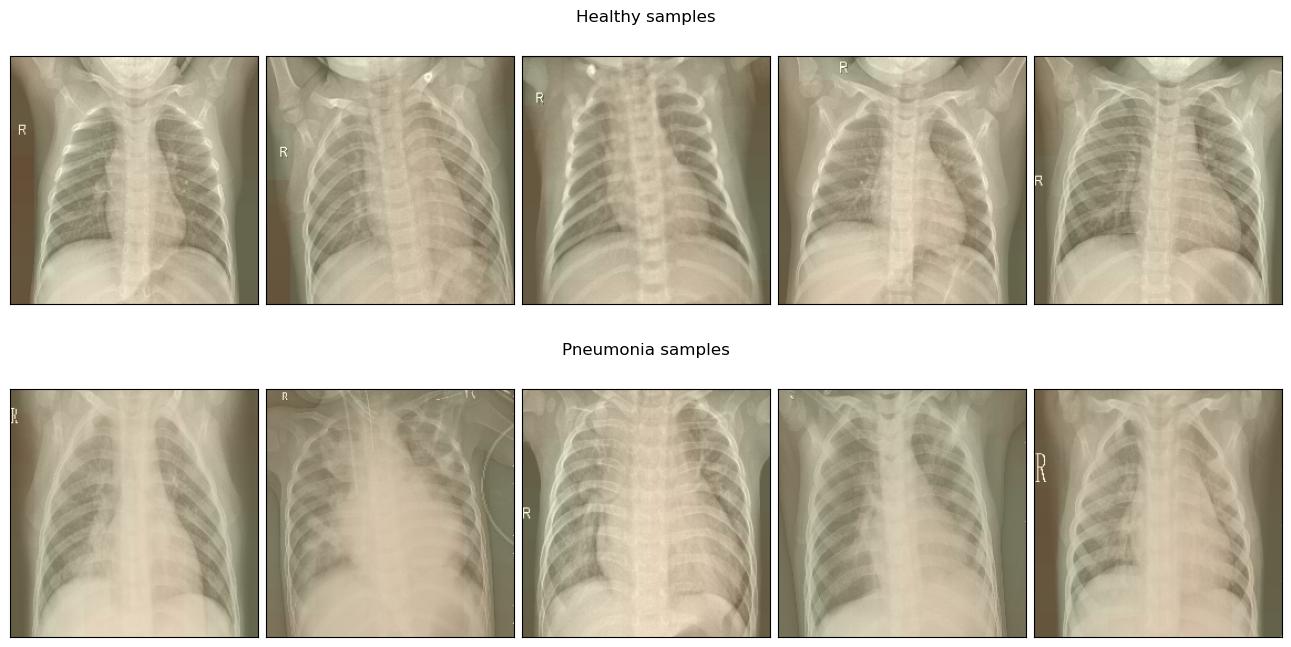

In [103]:
%%capture --no-display

fig = plt.figure(constrained_layout=True, figsize=[12.8, 6.6])
# fig.suptitle('Explaining outputs of model with GradCAM')
subfigs = fig.subfigures(nrows=2, ncols=1)

offset = 20

subfigs[0].suptitle("Healthy samples")
axes = subfigs[0].subplots(nrows=1, ncols=5)
for i, ax in enumerate(axes):
    input = train_dataset_orig[i+offset][0].unsqueeze(0).requires_grad_(True)
    attribution = gradCam(permuted_model, input)
    ax.imshow(visualise_gradCam(attribution, input))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

subfigs[1].suptitle("Pneumonia samples")
axes = subfigs[1].subplots(nrows=1, ncols=5)
for i, ax in enumerate(axes):
    input = train_dataset_orig[-(i+offset+1)][0].unsqueeze(0).requires_grad_(True)
    attribution = gradCam(permuted_model, input)
    ax.imshow(visualise_gradCam(attribution, input))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

### Interpretation

We see that both Integrated Gradients and GradCAM produce much different attribution maps for the model trained on data with randomly permuted labels in comparison to the attribution maps for the model trained on unpermuted data.

In the case of integrated gradients, the attribution maps of the model trained on pemruted data only highlight edges present in the image, such as ribs, whereas in the unpermuted case, the model showed very clear positive attributions in the areas of high density. 

In the case of GradCAM, in the permuted case, the attribution maps seem to assign a high importance to all regions of the image, making the attribution map completely uninformative. This is in stark contrast to the unpermuted case where in healthy samples, almost no regions were highlighted and in diseased samples, only the regions with increased density were highlighted.

In a nutshell, both methods "pass" the randomization test since their outputs differ greatly depending on whether the labels were permuted or unpermuted.